In [1]:
import pyodbc
import pandas as pd

#Using connection string to connect to the datalake
connection = pyodbc.connect("Driver={SnowflakeDSIIDriver}; Server=lq42418.eu-west-1.snowflakecomputing.com; Database=SMARTENERGI_DATALAKE; schema=public; UID=smartenergi_public_user; PWD=SmartEnergi2020!")
cus=connection.cursor()

#Executing the query on meter readings view
cus.execute("use warehouse compute_wh;")
select_stmt = """WITH energy_by_day as
(SELECT date(SRC:timestamp::datetime) as timestamp, SRC:metering_point_id::string as metering_point_id, sum(SRC:value::integer) as value, SRC:unit_of_measure::string as unit_of_measure
FROM "SMARTENERGI_DATALAKE"."PUBLIC"."METER_READINGS" 
WHERE PROPERTY = 'energy' and SRC:source_instance_name like '%oresundskraft%'
group by date(SRC:timestamp::datetime), SRC:metering_point_id, SRC:unit_of_measure), 

 days_per_station as
(select metering_point_id, min(timestamp), max(timestamp), count(*) as N
from energy_by_day
group by metering_point_id
order by count(*) desc)

select e.* 
from energy_by_day e
inner join (select metering_point_id
from days_per_station
where N>=1638) m on e.metering_point_id = m.metering_point_id
"""

df = pd.read_sql(select_stmt,connection)


In [2]:
 df_wide = df.pivot(index='TIMESTAMP',columns='METERING_POINT_ID', values = 'VALUE')

Euclidean k-means
8.052 --> 6.603 --> 6.435 --> 6.383 --> 6.357 --> 6.346 --> 6.340 --> 6.336 --> 6.333 --> 6.331 --> 6.331 --> 6.330 --> 6.330 --> 6.329 --> 6.328 --> 6.328 --> 6.328 --> 6.328 --> 6.328 --> 6.328 --> 6.327 --> 6.327 --> 6.327 --> 6.327 --> 6.327 --> 6.327 --> 6.327 --> 


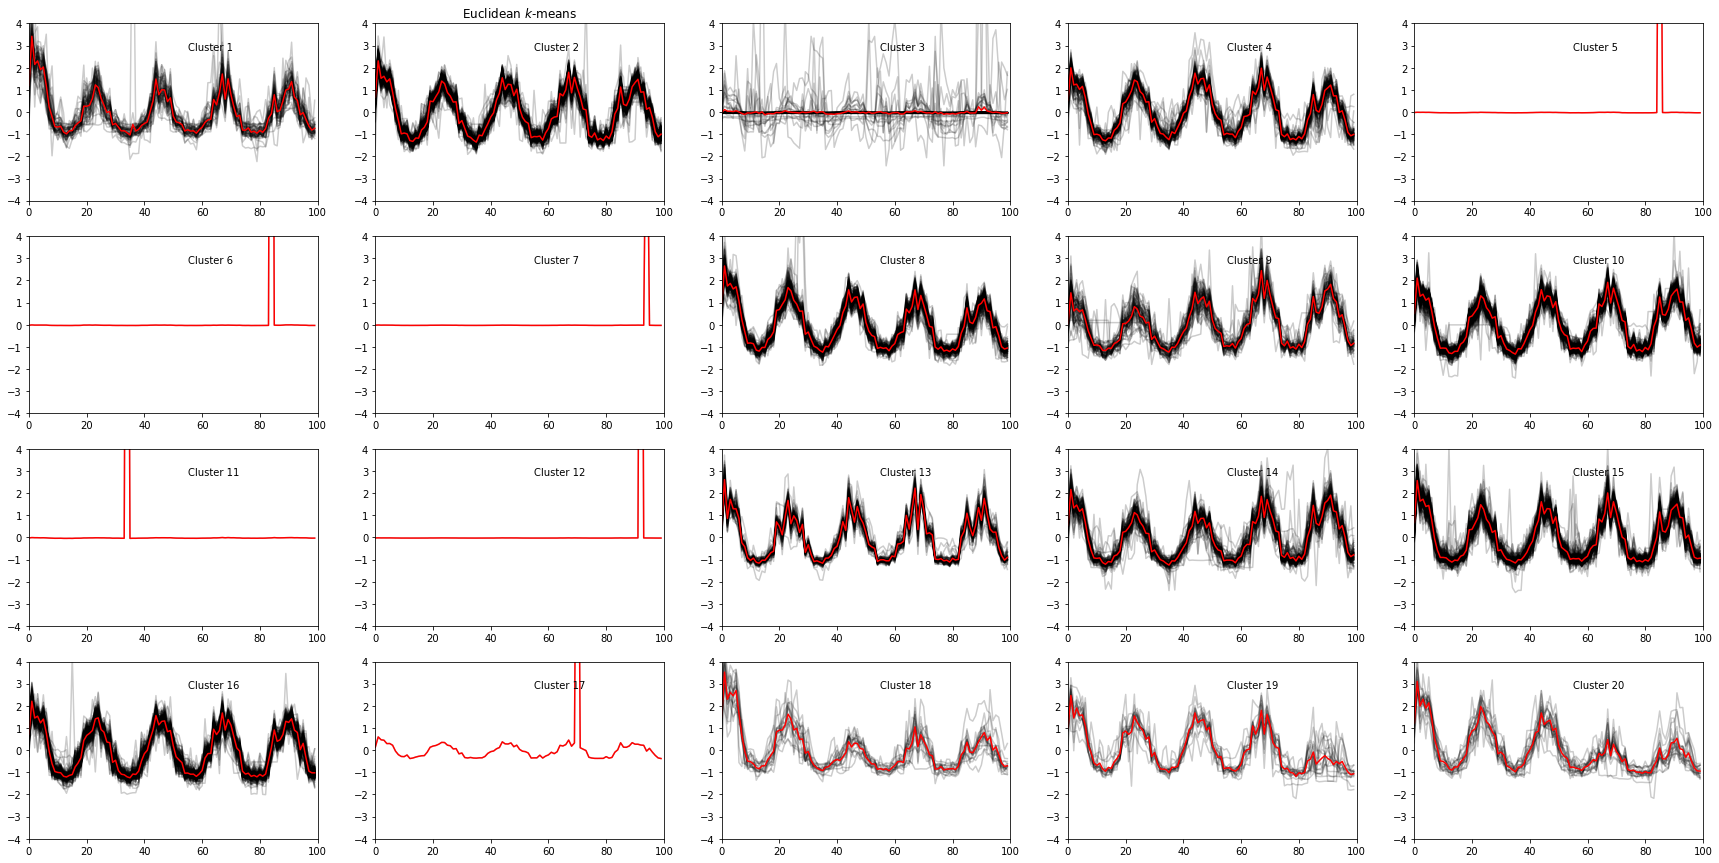

In [44]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import matplotlib.pyplot as plt

seed = 0
np.random.seed(seed)

X_train = TimeSeriesScalerMeanVariance().fit_transform(df_wide.transpose().values.tolist())

# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
#X_train.shape
#plt.plot(X_train[0])
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=20, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure(figsize=(30,15))
for yi in range(20):
    plt.subplot(4, 5, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

Fortsätt med kluster 16

In [45]:
df_group2 = df_wide.loc[:,list(y_pred==15)]
df_group2.shape

(1638, 282)

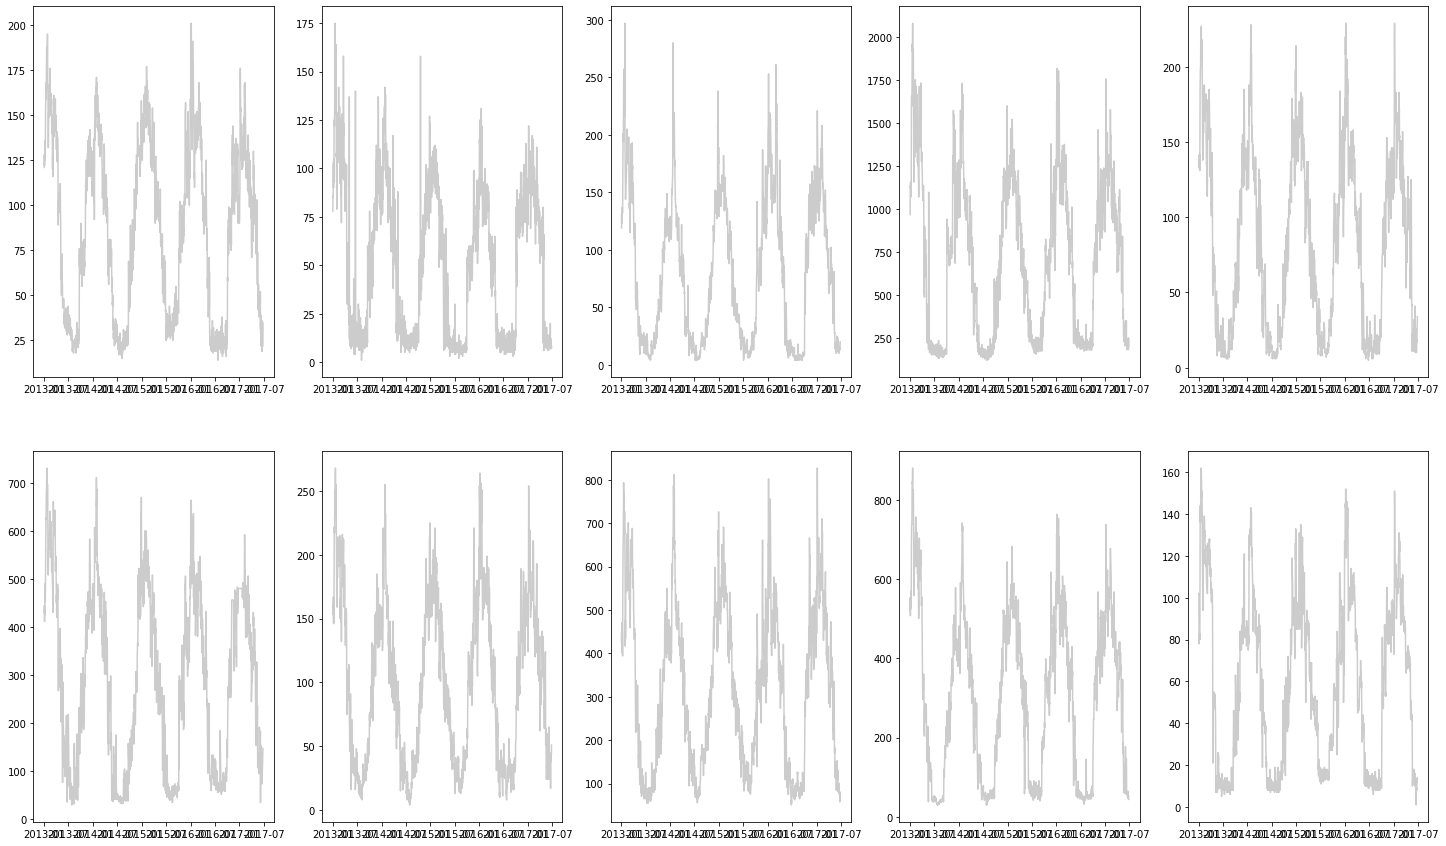

In [68]:
#seed=1
seed=10
np.random.seed(seed)

df_selected = df_group2.sample(10, axis=1)

plt.figure(figsize=(25,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    xx = df_selected[df_selected.columns[i]]
    plt.plot(xx, "k-", alpha=.2)

In [145]:
dfs = [df_selected[df_selected.columns[i]] for i in range(10)]
dfs = [df.rename('Konsumtion').to_frame() for df in dfs]
for df in dfs:
    df.index.names = ['Datum']
    
dfs[0].head()

,Konsumtion
Datum,
2013-01-01,121.0
2013-01-02,128.0
2013-01-03,122.0
2013-01-04,129.0
2013-01-05,125.0


## Inkludera väder

In [1]:
temp = pd.read_csv('data/HelsingborgA_lufttemperatur_dygn.csv', skiprows=9, sep=';')
temp['Representativt dygn'] = pd.to_datetime(temp['Representativt dygn'])- pd.DateOffset(days=1)
temp = temp[temp['Representativt dygn'] >= '2013-01-01'][['Representativt dygn', 'Lufttemperatur']]
temp.columns = ['Datum', 'Temperatur']
temp.set_index('Datum', inplace=True)

daggpunkt = pd.read_csv('data/HelsingborgA_daggpunkt_h.csv', skiprows=9, sep=';', low_memory=False)
daggpunkt['Datum'] = pd.to_datetime(daggpunkt['Datum'])- pd.DateOffset(days=1)
daggpunkt = daggpunkt[daggpunkt.Datum >= '2013-01-01']
daggpunkt = daggpunkt.groupby('Datum')['Daggpunktstemperatur'].mean()

lufttryck = pd.read_csv('data/HelsingborgA_Lufttryck_h.csv', skiprows=9, sep=';', low_memory=False) 
lufttryck['Datum'] = pd.to_datetime(lufttryck['Datum'])- pd.DateOffset(days=1)
lufttryck = lufttryck[lufttryck.Datum >= '2013-01-01']
lufttryck = lufttryck.groupby('Datum')['Lufttryck reducerat havsytans nivå'].mean()
lufttryck = lufttryck.rename('Lufttryck')

vind = pd.read_csv('data/HelsingborgA_Vind_h.csv', skiprows=9, sep=';', low_memory=False)
vind['Datum'] = pd.to_datetime(vind['Datum']) - pd.DateOffset(days=1)
vind = vind[vind.Datum >= '2013-01-01']
vind = vind.groupby('Datum')[['Vindriktning', 'Vindhastighet']].mean()

nb_mängd = pd.read_csv('data/HelsingborgA_nederbördsmängd_dygn.csv', skiprows=9, sep=';', low_memory=False)
nb_mängd['Representativt dygn'] = pd.to_datetime(nb_mängd['Representativt dygn'])- pd.DateOffset(days=1)
nb_mängd = nb_mängd[nb_mängd['Representativt dygn'] >= '2013-01-01'][['Representativt dygn', 'Nederbördsmängd']]
nb_mängd.columns = ['Datum', 'Nederbördsmängd']
nb_mängd.set_index('Datum', inplace=True)

weather = temp.join(nb_mängd).join(vind).join(lufttryck).join(daggpunkt)
weather = weather.interpolate(method='linear')

In [2]:
weather.isna().sum()

Temperatur              0
Nederbördsmängd         0
Vindriktning            0
Vindhastighet           0
Lufttryck               0
Daggpunktstemperatur    0
dtype: int64

In [162]:
dfs_weather = [df.join(weather, how='left') for df in dfs]
dfs_weather[0].tail()

,Konsumtion,Temperatur,Nederbördsmängd,Vindriktning,Vindhastighet,Lufttryck,Daggpunktstemperatur
Datum,,,,,,,
2017-06-22,25.0,16.6,5.5,169.083333,2.562500,1005.937500,13.991667
2017-06-23,30.0,15.5,4.0,246.750000,4.058333,1005.070833,12.008333
2017-06-24,35.0,15.3,3.0,238.416667,5.500000,1003.145833,8.937500
2017-06-25,26.0,14.4,0.0,264.625000,5.720833,1005.208333,7.087500
2017-06-26,22.0,14.9,0.0,227.291667,2.729167,1010.683333,6.687500


## Inkludera K2 regression
Väljer 2014 som referensår för alla anläggningar

In [152]:
from backend.Matrix import Matrix
from backend.Group import Group
from backend.Point import Point

#temperaturintervall, hårdkodat i _default_controller.py
BREAKPOINTS = [-5, 2, 9, 15, 20]

def fill_points_with_data(df):
    points = []
    for index, row in df.iterrows():
        point = Point()
        point.temp = float(row['Temperatur'])
        try:
            point.reading = row['Konsumtion'] 
            point.timestamp = row['Datum']
            point.consumption_timestamp = row['Datum']
            point.breakpoints = BREAKPOINTS
        except:
            None
        points.append(point)
    return points

def train_K2(df, d_min, d_max, output_name = 'K2_regression', normalize=False):
    points_energy_ref = fill_points_with_data(df[(df.index >= d_min) & (df.index <= d_max)])
    points_energy = fill_points_with_data(df)

    g_energy_ref = Group()
    g_energy_ref.set_breakpoints(BREAKPOINTS)
    g_energy_ref.set_points(points_energy_ref)
    
    g_energy = Group()
    g_energy.set_breakpoints(BREAKPOINTS)
    g_energy.set_points(points_energy)
    
    koff = g_energy_ref.calcKoff()
    g_energy.updatePointRegression(koff)
    
    df[output_name] = [point.regression for point in g_energy.points]
    if normalize:
        #Skapa data grupp för breakpoints för visualisering av modell
        breakpoint_df = pd.DataFrame({'Temperatur' : BREAKPOINTS})
        points_bp = fill_points_with_data(breakpoint_df)
        bp_group = Group()
        bp_group.set_breakpoints(BREAKPOINTS)
        bp_group.set_points(points_bp)
        bp_group.updatePointRegression(koff)
        df['Konsumtion'] = 130 * (df['Konsumtion'] / bp_group.points[0].regression)
    return df



In [153]:
dfs_weather_K2_norm = [train_K2(df, d_min ='2014-01-01', d_max = '2014-12-31', output_name = 'K2_regression', normalize=True) for df in dfs_weather]

In [154]:
dfs_weather_K2_norm2 = [train_K2(df, d_min ='2014-01-01', d_max = '2014-12-31', output_name = 'K2_regression', normalize=False) for df in dfs_weather_K2_norm]

In [155]:
dfs_weather_K2_norm2[0]

,Konsumtion,Temperatur,Nederbördsmängd,Vindriktning,Vindhastighet,Lufttryck,Daggpunktstemperatur,K2_regression
Datum,,,,,,,,
2013-01-01,101.254218,3.9,7.6,249.125000,3.525000,1009.579167,2.520833,108.273268
2013-01-02,107.111900,6.4,0.0,266.458333,7.191667,1012.695833,4.620833,92.933346
2013-01-03,102.091030,6.0,0.4,301.916667,5.833333,1018.775000,4.420833,95.387733
2013-01-04,107.948712,2.4,1.2,144.958333,1.141667,1026.116667,2.158333,117.477221
2013-01-05,104.601465,4.4,1.9,196.916667,1.833333,1022.154167,3.762500,105.205283
...,...,...,...,...,...,...,...,...
2017-06-22,20.920293,16.6,5.5,169.083333,2.562500,1005.937500,13.991667,26.114716
2017-06-23,25.104352,15.5,4.0,246.750000,4.058333,1005.070833,12.008333,27.698747
2017-06-24,29.288410,15.3,3.0,238.416667,5.500000,1003.145833,8.937500,27.986753


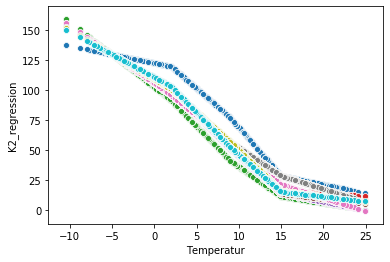

In [156]:
for i, df in enumerate(dfs_weather_K2_norm2):
    sns.scatterplot(x='Temperatur', y='K2_regression', data=df)

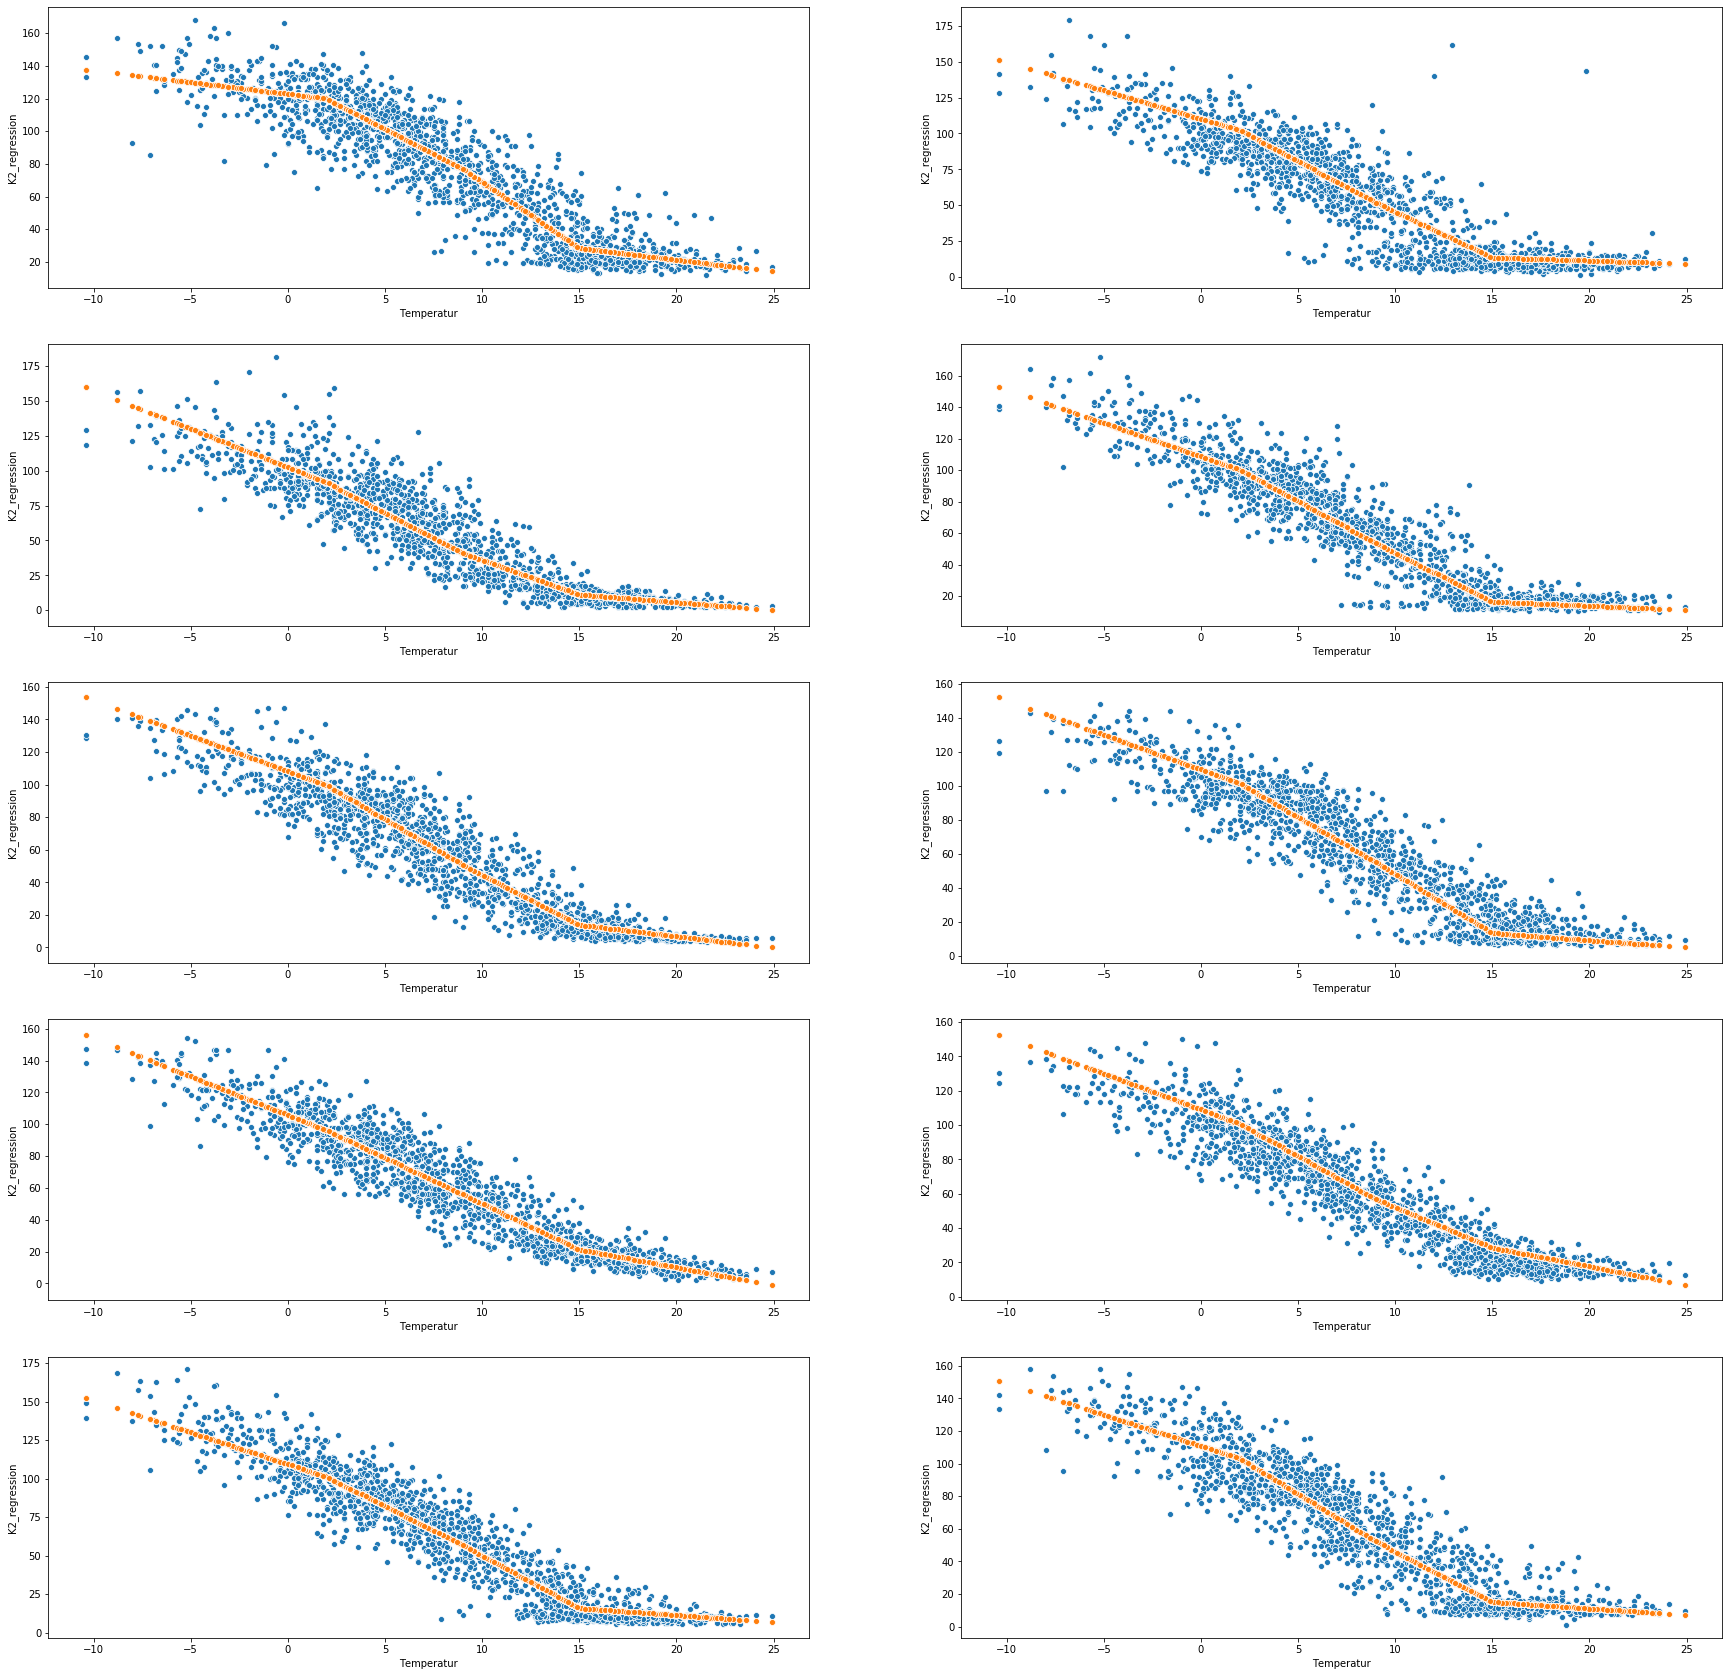

In [157]:
import seaborn as sns

plt.figure(figsize=(30,30))
for i, df in enumerate(dfs_weather_K2_norm2):
    plt.subplot(5, 2, i+1)
    sns.scatterplot(x='Temperatur', y='Konsumtion', data=df)
    sns.scatterplot(x='Temperatur', y='K2_regression', data=df)

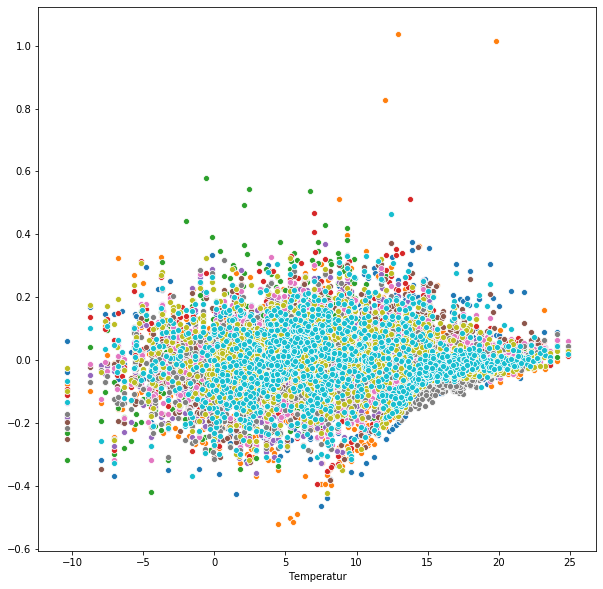

In [159]:
import seaborn as sns

plt.figure(figsize=(10,10))
for i, df in enumerate(dfs_weather_K2):
    #plt.subplot(5, 2, i+1)
    sns.scatterplot(df['Temperatur'], df['Konsumtion'] - df['K2_regression'])

## Skriv till csv
Två filer per station, en med all data och en utan valideringsdata (2017-01-01 tom 2017-06-26) som kommer ges till tävlingsdeltagarna

In [160]:
for i, df in enumerate(dfs_weather_K2_norm2):
    df.to_csv('data_competition/Station_{}_full.csv'.format(i+1))
    df[df.index <= pd.to_datetime('2016-12-31')].to_csv('data_competition/Station_{}.csv'.format(i+1))

In [6]:
weather[(weather.index>=pd.to_datetime('2017-01-01')) & (weather.index<=pd.to_datetime('2017-06-26'))].to_csv('data_competition/Väder_valideringsperiod.csv')